# Kommasetzung by Till Nöllgen

With this little program we try to predict at which positions in any kind of german text there is a comma. 
For this we use a LSTM network that we train with random free available german books online. In the hope that they properly use the comma rules. For better readablility I wrote the program in this jupyter notebook, because it lets me combine text and code in the same sheet as well print out preliminary statuses. The project was inspired from previouse code from Udacity's Deep Learning Nanodegree and variouse scientific papers about sentiment analysis and word2vec - research.

In [1]:
import os
import io
import csv
import sys
import time
import re
import string
from collections import Counter
import numpy as np
import tensorflow as tf
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Make sure to use Tensorflow 1.0.x

In [2]:
print(tf.VERSION)

1.0.1


# Load dataset
Data set is made out of 12 online free available books (Like for example "Harry Potter - Der Stein der Weisen")

In [66]:
with open('wikiextractor/text/books/untitled.txt', "r", encoding="utf-8") as text:
    text = text.read()
    
### Posibility to shrink down dataset for faster processing if wanted!!!
text = text[:]

#Minimal dataset cleaning by removing the page numbers as well single standing words 
text = re.sub(r'\n[0-9]+ \n', '', text)
text = re.sub(r'\n\n[a-zA-Z] \n\n', '', text)

print(text[:100])

Die beiden schweren Koffer bereiteten meinen Armen ziemliche Schmerzen. Doch da musste ich ab jetzt 


# Tokenizing into words

In [67]:
#TOKENIZING INTO WORDS
from nltk.tokenize import word_tokenize

woerter = word_tokenize(text)
print(woerter[:100])

['Die', 'beiden', 'schweren', 'Koffer', 'bereiteten', 'meinen', 'Armen', 'ziemliche', 'Schmerzen', '.', 'Doch', 'da', 'musste', 'ich', 'ab', 'jetzt', 'durch', '.', 'Von', 'nun', 'an', 'würde', 'mir', 'keiner', 'mehr', 'die', 'Sachen', 'abnehmen', 'oder', 'mir', 'ein', 'schönes', ',', 'heißes', 'Bad', 'vorbereiten', '.', 'Mein', 'Vater', 'war', 'ein', 'sehr', 'reicher', 'Geschäftsmann', ',', 'der', 'gerade', 'ein-', 'bis', 'zweimal', 'im', 'Jahr', 'Zuhause', 'war', '.', 'Und', 'meine', 'Mutter', 'war', 'tot', '.', 'Leider', '.', 'Deswegen', 'wurde', 'ich', 'gezwungen', ',', 'bis', 'zu', 'meinem', 'achtzehnten', 'Lebensjahr', 'auf', 'das', 'Helmut-Kohl-Internat', 'in', 'Nordkanada', 'zu', 'gehen', '.', 'Bis', 'dahin', 'waren', 'es', 'aber', 'noch', 'drei', 'ganze', 'Jahre', '!', 'Ich', 'musste', 'bei', 'dem', 'Gedanken', 'leise', 'seufzen', '.', 'Endlich']


# Stemming

In [68]:
#STEMMING
x = (len(set(woerter)))
sno = nltk.stem.SnowballStemmer('german')
woerter_stem = [sno.stem(wort) for wort in woerter]
y = (len(set(woerter_stem)))

print(str((x-y)*100/(x)) +" percent of the words saved by using stemming")

2265065
33.52881265076387 Prozent an Wörter gespart durch Stemming


In [69]:
counts = Counter(woerter_stem)
print(counts.most_common(20))

[(',', 141610), ('.', 128611), ('und', 54952), ('ich', 46348), ('ein', 37448), ('sie', 36473), ('die', 35952), ('er', 28278), ('nicht', 27730), ('war', 27518), ('“', 27125), ('das', 24372), ('es', 23695), ('der', 23509), ('zu', 23375), ('in', 22560), ('?', 20957), ('ihr', 18536), ('sich', 18154), ('auf', 17681)]


Actually here you can see how many commas are in the training data. Normally it is around every 10th word...

# Lemmatization

In this project the "TIGER Corpus Release 2.1" of the university Stuttgart was used. Make sure to adjust the root of the corpus depending where it is safed (unzipped 60 MB)

http://www.ims.uni-stuttgart.de/forschung/ressourcen/korpora/TIGERCorpus/download/start.html

https://datascience.blog.wzb.eu/2016/07/13/accurate-part-of-speech-tagging-of-german-texts-with-nltk/



In [70]:
# GERMAN WORD CLASSES / LEXICAL CATEGORIES
from nltk.tag import UnigramTagger

'''
    WORDS = 'words'   #: column type for words
    POS = 'pos'       #: column type for part-of-speech tags
    TREE = 'tree'     #: column type for parse trees
    CHUNK = 'chunk'   #: column type for chunk structures
    NE = 'ne'         #: column type for named entities
    SRL = 'srl'       #: column type for semantic role labels
    IGNORE = 'ignore' #: column type for column that should be ignored

    #: A list of all column types supported by the conll corpus reader.
    COLUMN_TYPES = (WORDS, POS, TREE, CHUNK, NE, SRL, IGNORE)
'''

#Choose the root depending on if you run it on a server (FLOYDHUB) or on your local CPU/GPU
root = '/output/'
#root = '/Users/Till/Dropbox/Deep Learning Udacity/deep-learning/KommasetzungAusweichordner'
fileid = 'tiger_release_aug07.corrected.16012013.conll09'
columntypes = ['ignore', 'words', 'ignore', 'ignore', 'pos']

corp = nltk.corpus.ConllCorpusReader(root, fileid, columntypes, encoding='utf8')
tagged_sents = corp.tagged_sents()
tagger = UnigramTagger(corp.tagged_sents())

#WORD CLASSIFICATION
w_classes = tagger.tag(woerter)

In [71]:
print(w_classes[:10])

[('Die', 'ART'), ('beiden', 'PIAT'), ('schweren', 'ADJA'), ('Koffer', 'NN'), ('bereiteten', 'VVFIN'), ('meinen', 'VVFIN'), ('Armen', 'NN'), ('ziemliche', None), ('Schmerzen', 'NN'), ('.', '$.'), ('Doch', 'KON'), ('da', 'ADV'), ('musste', None), ('ich', 'PPER'), ('ab', 'PTKVZ'), ('jetzt', 'ADV'), ('durch', 'APPR'), ('.', '$.'), ('Von', 'APPR'), ('nun', 'ADV')]


In [72]:
woerter_classes = []

for word in w_classes:
    if "$" in str(word[1]):
        word_class = word[0] + "c"
    else:
        word_class = word[1]
    woerter_classes.append(word_class)

In [73]:
print(woerter_classes[:30])

['ART', 'PIAT', 'ADJA', 'NN', 'VVFIN', 'VVFIN', 'NN', None, 'NN', '.c', 'KON', 'ADV', None, 'PPER', 'PTKVZ', 'ADV', 'APPR', '.c', 'APPR', 'ADV', 'APPR', 'VAFIN', 'PPER', 'PIS', 'ADV', 'ART', 'NN', 'VVINF', 'KON', 'PPER', 'ART', 'ADJA', ',c', 'ADJA', 'NE', 'VVINF', '.c', 'PPOSAT', 'NN', 'VAFIN', 'ART', 'ADV', 'ADJD', 'NN', ',c', 'ART', 'ADV', 'TRUNC', 'APPR', 'ADV']


# Transform words into numbers

In [74]:
vocab = sorted(counts, key=counts.get, reverse=True)

counts_classes = Counter(woerter_classes)
vocab_classes = sorted(counts_classes, key=counts_classes.get, reverse=True)

vocabs = vocab + vocab_classes
print(str(len(vocabs)) +" unique words/lemmas in the lookup table")

vocabs_to_int = {wort: i for i, wort in enumerate(vocabs, 1)}
int_to_vocabs = {wort: i for i, wort in vocabs_to_int.items()}

62065


# Setting labels

If word is a comma, then the label is "1" otherwise "0"

In [75]:
labels = []
#for idx, wort in enumerate(woerter,0):
for wort in woerter:
    if wort == ",":
        labels.append(1)
        #labels.append([1, wort])
    else:
        labels.append(0)
        #labels.append([0, wort])    

print(labels[:40])
print(woerter[:40])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['Die', 'beiden', 'schweren', 'Koffer', 'bereiteten', 'meinen', 'Armen', 'ziemliche', 'Schmerzen', '.', 'Doch', 'da', 'musste', 'ich', 'ab', 'jetzt', 'durch', '.', 'Von', 'nun', 'an', 'würde', 'mir', 'keiner', 'mehr', 'die', 'Sachen', 'abnehmen', 'oder', 'mir', 'ein', 'schönes', ',', 'heißes', 'Bad', 'vorbereiten', '.', 'Mein', 'Vater', 'war']


# Removing Commas
Let's remove comma placeholder in the labels and the text: That means a word after a comma now will become the label "1" instead of "0" and one "0" will be removed as well as all comma and comma synonyms will be removed.

In [78]:
labels_indicator = np.roll(labels, 1)
labels = [labels[i] for i in range(0,len(labels)) if labels_indicator[i] != 1]
labels = np.asarray(labels)

woerter = [woerter[i] if labels_indicator[i] != 1 else (", " + woerter[i]) for i in range(0,len(woerter))]
woerter = [wort for wort in woerter if wort!= ","]
woerter_stem = [wort for wort in woerter_stem if wort!= ","]
woerter_classes = [wort for wort in woerter_classes if wort!= ",c"]

# Transform text to numbers

In [84]:
woerter_ints = [vocabs_to_int[wort] for wort in woerter_stem]
woerter_classes_ints = [vocabs_to_int[wort] for wort in woerter_classes]

print(woerter_ints[:10])
print(woerter_classes_ints[:10])

[62006, 62024, 62014, 62004, 62010, 62010, 62004, 62002, 62004, 62009, 62012, 62005, 62002, 62003, 62033, 62005, 62008, 62009, 62008, 62005, 62008, 62011, 62003, 62025, 62005, 62006, 62004, 62016, 62012, 62003, 62006, 62014, 62014, 62023, 62016, 62009, 62015, 62004, 62011, 62006, 62005, 62013, 62004, 62006, 62005, 62059, 62008, 62005, 62026, 62004]


# Making features

### So what the function actually does:

You feed in the index of the word and get out a list of 20 digits (depends on the window size). The first ten digits are the ten stemmed words behind the index-word/comma. The second ten digits are the same ten words behind the index-word/comma but representing the word classification (also know as Lemmatization). In the beginning I also experimented by feeding in words that stand in front of the index-word/comma. But actually the network already has "seen" those words and "interpreted" the most important informations of it (by the way a LSTM-network works). I also experimented with randomizing the window size based on a idea of [Mikolov et al.](https://arxiv.org/pdf/1301.3781.pdf) (word to vector research). But no positive effect could be seen, so I simplified it again.

In [85]:
def get_batch(woerter_ints, idx, window_size=10): # woerter_ints should be woerter_ints or woerter_classes_ints 
                                  
    #r = np.random.randint(5, window_size+1)
    r = window_size
    
    #lower Boundaries for the beginning of the data set
    if idx - r < 0:
        minus_idx = 0
    else:
        minus_idx = idx - r
        
    #upper Boundaries for the ending of the data set   
    if idx + r > len(woerter_ints):
        plus_idx = len(woerter_ints)
    else:
        plus_idx = idx + r
        
        
    #davor = woerter_ints[minus_idx:idx]
    danach = woerter_ints[idx:plus_idx]
    
    #x_davor = ([0]*(window_size-len(davor))) + davor
    x_danach = danach + ([0]*(window_size-len(danach)))
    
    #x = x_davor + x_danach
    x = x_danach
    
    return x
        

In [86]:
features = []
feature_woerter = [get_batch(woerter_ints, idx, window_size=10) for idx in range(0,len(labels))]
feature_classes =  [get_batch(woerter_classes_ints, idx, window_size=10) for idx in range(0,len(labels))]
features = list(zip(feature_woerter, feature_classes))
features = np.asarray(features).reshape(len(labels), -1)

print(features.shape)

(2123455, 20)


In [87]:
print(features[2:4])

[[  362  1134  2075    24   142   352   423     2    53    67 62014 62004
  62010 62010 62004 62002 62004 62009 62012 62005]
 [ 1134  2075    24   142   352   423     2    53    67    81 62004 62010
  62010 62004 62002 62004 62009 62012 62005 62002]
 [ 2075    24   142   352   423     2    53    67    81     4 62010 62010
  62004 62002 62004 62009 62012 62005 62002 62003]
 [   24   142   352   423     2    53    67    81     4   190 62010 62004
  62002 62004 62009 62012 62005 62002 62003 62033]
 [  142   352   423     2    53    67    81     4   190    66 62004 62002
  62004 62009 62012 62005 62002 62003 62033 62005]
 [  352   423     2    53    67    81     4   190    66   108 62002 62004
  62009 62012 62005 62002 62003 62033 62005 62008]
 [  423     2    53    67    81     4   190    66   108     2 62004 62009
  62012 62005 62002 62003 62033 62005 62008 62009]
 [    2    53    67    81     4   190    66   108     2    37 62009 62012
  62005 62002 62003 62033 62005 62008 62009 62008]


# Splitting into training, validation & test set
90% of the dataset is getting used for training. 5% will be used for validation in between and 5% for testing in the end

In [92]:
split_idx = int(len(features)*0.95)

print(features.shape)
print(labels.shape)

train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]
train_woerter, val_woerter = woerter_stem[:split_idx], woerter_stem[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]
val_woerter, test_woerter = val_woerter[:test_idx], val_woerter[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape), 
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

(2123455, 20)
(2123455,)
			Feature Shapes:
Train set: 		(2017282, 20) 
Validation set: 	(53086, 20) 
Test set: 		(53087, 20)


# Build the graph
Here, we'll build the graph. First up, defining the hyperparameters.

lstm_size: Number of units in the hidden layers in the LSTM cells. Started with 128 but scaled it up to 256 and then 512, because of better performance

lstm_layers: Number of LSTM layers in the network. I'm using 3 because it seems to be a reasonable number for such a task

batch_size: The number of reviews to feed the network in one training pass. Higher means faster, but also you can get stuck in local minima. 128 & 256 seemed to be a good trade off

learning_rate: Learning rate was in the beginning 0.0005 (inspired by word-to-vec) but I lowered it to 0.0003 because of better performance

In [93]:
lstm_size = 512 # 512
lstm_layers = 3 # 3
batch_size = 256 # 128
learning_rate = 0.0003 #0.0005

We'll also be using dropout on the LSTM layer, so we'll make a placeholder for the keep probability.

In [94]:
n_words = (len(vocabs_to_int)) + 1 # Adding 1 because we use 0's for padding, dictionary started at 1


# Create the graph object
graph = tf.Graph()
# Add nodes to the graph
with graph.as_default():
    inputs_ = tf.placeholder(tf.int32, [None, None], name='inputs')
    labels_ = tf.placeholder(tf.int32, [None, None], name='labels')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# Embedding

Now we'll add an embedding layer. We need to do this because there are thousands of words in our vocabulary. It is massively inefficient to one-hot encode our classes here (learned from word2vec) Instead of one-hot encoding, we can have an embedding layer and use that layer as a lookup table.

In [95]:
# Size of the embedding vectors (number of units in the embedding layer)
embed_size = 300 #300

with graph.as_default():
    embedding = tf.Variable(tf.truncated_normal((n_words, embed_size), stddev = 0.3))
    #embedding = tf.Variable(tf.random_uniform((n_words, embed_size), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs_)

In [96]:
with graph.as_default():
    # The basic LSTM cell
    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
    
    # Add dropout to the cell
    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)
    
    # Stack up multiple LSTM layers, for deep learning
    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)
    
    # Getting an initial state of all zeros
    initial_state = cell.zero_state(batch_size, tf.float32)

In [97]:
with graph.as_default():
    outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state=initial_state)

# Output

We only care about the final output, we'll be using that as our comma prediction. So we need to grab the last output with `outputs[:, -1]`, the calculate the cost from that and `labels_`.

In [98]:
with graph.as_default():
    predictions = tf.contrib.layers.fully_connected(outputs[:, -1], 1, activation_fn=tf.sigmoid)
    cost = tf.losses.mean_squared_error(labels_, predictions)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Here we can add a few nodes to calculate the accuracy which we'll use in the validation pass.

In [99]:
with graph.as_default():
    correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.int32), labels_)
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Batching

This is a simple function for returning batches from our data. First it removes data such that we only have full batches. Then it iterates through the `x` and `y` arrays and returns slices out of those arrays with size `[batch_size]`.

In [100]:
def get_batches(x, y, woerter, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y, woerter = x[:n_batches*batch_size], y[:n_batches*batch_size], woerter[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size], woerter[ii:ii+batch_size]### Batching


# Training

Training of the LSTM. Taking time measurements all the way. Saving checkpoints when the training accuracy exceeds prior results. 

num_epochs: because of time and money constraints the network never was trained more than 10 hours (8 epochs) but normally there werent that huge improvments seen anymore after 2 epochs

In [101]:
num_epochs = 8

file_output = "data.txt"

cathegory = ["epochs", "iteration", "val_accuracies"]

with graph.as_default():
    saver = tf.train.Saver(max_to_keep=1) # keep last best iteration
    

START
Epoch: 0/8 Iteration: 0 Train loss: 0.249
10 Epochs training time: 0.277 s
Val acc: 0.925
1 Validation time: 10.999 s


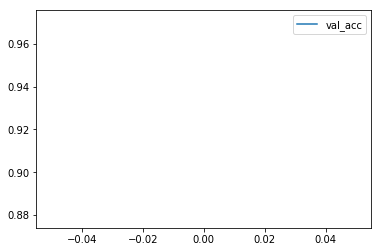

Ploting time: 0.202 s
New best saving time: 2.83 s
Epoch: 0/8 Iteration: 10 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 20 Train loss: 0.035
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 30 Train loss: 0.059
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 40 Train loss: 0.043
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 50 Train loss: 0.043
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 60 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 70 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 80 Train loss: 0.047
10 Epochs training time: 0.186 s
Epoch: 0/8 Iteration: 90 Train loss: 0.062
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 100 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 110 Train loss: 0.102
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 120 Train loss: 0.043
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 130 Train lo

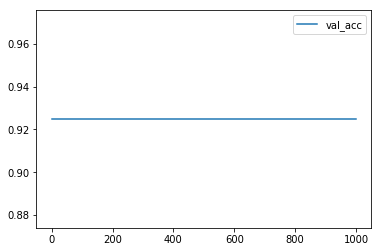

Ploting time: 0.176 s
Epoch: 0/8 Iteration: 1010 Train loss: 0.055
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 1020 Train loss: 0.070
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 1030 Train loss: 0.051
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 1040 Train loss: 0.055
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 1050 Train loss: 0.059
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 1060 Train loss: 0.043
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 1070 Train loss: 0.051
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 1080 Train loss: 0.039
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 1090 Train loss: 0.051
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 1100 Train loss: 0.066
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 1110 Train loss: 0.055
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 1120 Train loss: 0.066
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 1130 Train loss: 0.0

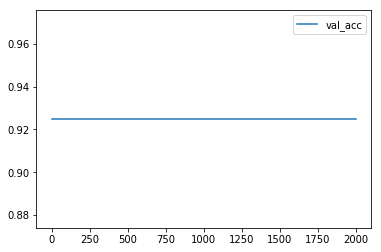

Ploting time: 0.201 s
Epoch: 0/8 Iteration: 2010 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 2020 Train loss: 0.059
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 2030 Train loss: 0.039
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 2040 Train loss: 0.098
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 2050 Train loss: 0.066
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 2060 Train loss: 0.051
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 2070 Train loss: 0.051
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 2080 Train loss: 0.090
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 2090 Train loss: 0.051
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 2100 Train loss: 0.066
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 2110 Train loss: 0.062
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 2120 Train loss: 0.070
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 2130 Train loss: 0.0

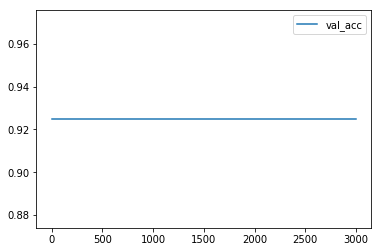

Ploting time: 0.165 s
Epoch: 0/8 Iteration: 3010 Train loss: 0.066
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 3020 Train loss: 0.047
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 3030 Train loss: 0.059
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 3040 Train loss: 0.074
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 3050 Train loss: 0.020
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 3060 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 3070 Train loss: 0.012
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 3080 Train loss: 0.020
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 3090 Train loss: 0.043
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 3100 Train loss: 0.027
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 3110 Train loss: 0.023
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 3120 Train loss: 0.031
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 3130 Train loss: 0.0

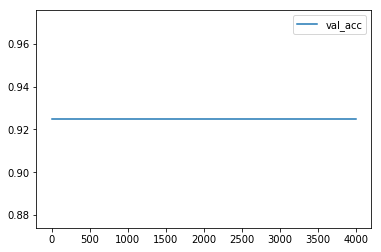

Ploting time: 0.171 s
Epoch: 0/8 Iteration: 4010 Train loss: 0.085
10 Epochs training time: 0.187 s
Epoch: 0/8 Iteration: 4020 Train loss: 0.092
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 4030 Train loss: 0.065
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 4040 Train loss: 0.104
10 Epochs training time: 0.186 s
Epoch: 0/8 Iteration: 4050 Train loss: 0.085
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 4060 Train loss: 0.075
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 4070 Train loss: 0.062
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 4080 Train loss: 0.082
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 4090 Train loss: 0.066
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 4100 Train loss: 0.079
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 4110 Train loss: 0.072
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 4120 Train loss: 0.069
10 Epochs training time: 0.186 s
Epoch: 0/8 Iteration: 4130 Train loss: 0.0

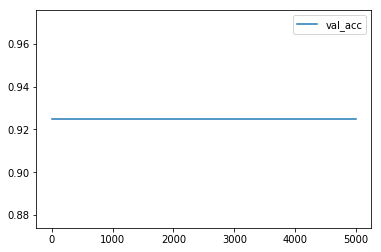

Ploting time: 0.179 s
Epoch: 0/8 Iteration: 5010 Train loss: 0.079
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 5020 Train loss: 0.076
10 Epochs training time: 0.186 s
Epoch: 0/8 Iteration: 5030 Train loss: 0.070
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 5040 Train loss: 0.066
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 5050 Train loss: 0.049
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 5060 Train loss: 0.065
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 5070 Train loss: 0.052
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 5080 Train loss: 0.041
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 5090 Train loss: 0.023
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 5100 Train loss: 0.041
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 5110 Train loss: 0.070
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 5120 Train loss: 0.052
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 5130 Train loss: 0.0

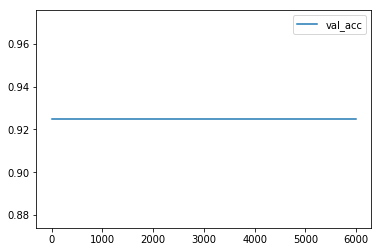

Ploting time: 0.152 s
Epoch: 0/8 Iteration: 6010 Train loss: 0.082
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 6020 Train loss: 0.082
10 Epochs training time: 0.186 s
Epoch: 0/8 Iteration: 6030 Train loss: 0.064
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 6040 Train loss: 0.068
10 Epochs training time: 0.186 s
Epoch: 0/8 Iteration: 6050 Train loss: 0.062
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 6060 Train loss: 0.043
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 6070 Train loss: 0.044
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 6080 Train loss: 0.067
10 Epochs training time: 0.186 s
Epoch: 0/8 Iteration: 6090 Train loss: 0.061
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 6100 Train loss: 0.071
10 Epochs training time: 0.186 s
Epoch: 0/8 Iteration: 6110 Train loss: 0.073
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 6120 Train loss: 0.091
10 Epochs training time: 0.183 s
Epoch: 0/8 Iteration: 6130 Train loss: 0.0

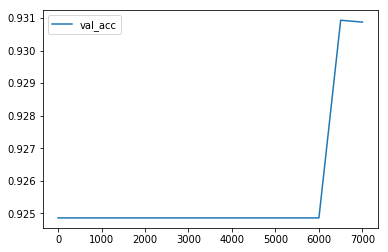

Ploting time: 0.163 s
Epoch: 0/8 Iteration: 7010 Train loss: 0.042
10 Epochs training time: 0.183 s
Epoch: 0/8 Iteration: 7020 Train loss: 0.041
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 7030 Train loss: 0.073
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 7040 Train loss: 0.048
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 7050 Train loss: 0.076
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 7060 Train loss: 0.039
10 Epochs training time: 0.185 s
Epoch: 0/8 Iteration: 7070 Train loss: 0.080
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 7080 Train loss: 0.042
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 7090 Train loss: 0.059
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 7100 Train loss: 0.070
10 Epochs training time: 0.184 s
Epoch: 0/8 Iteration: 7110 Train loss: 0.066
10 Epochs training time: 0.186 s
Epoch: 0/8 Iteration: 7120 Train loss: 0.056
10 Epochs training time: 0.186 s
Epoch: 0/8 Iteration: 7130 Train loss: 0.0

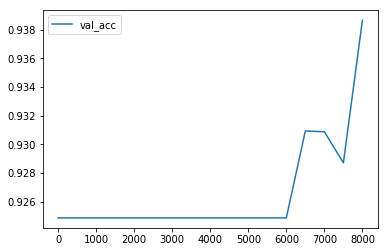

Ploting time: 0.243 s
New best saving time: 2.822 s
Epoch: 1/8 Iteration: 8010 Train loss: 0.027
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 8020 Train loss: 0.048
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 8030 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 8040 Train loss: 0.032
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 8050 Train loss: 0.024
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 8060 Train loss: 0.028
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 8070 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 8080 Train loss: 0.026
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 8090 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 8100 Train loss: 0.055
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 8110 Train loss: 0.026
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 8120 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 1/8 I

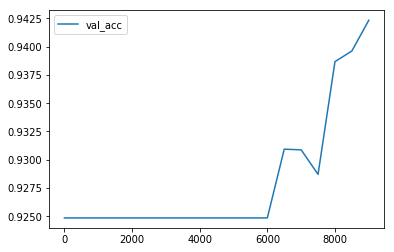

Ploting time: 0.198 s
New best saving time: 2.794 s
Epoch: 1/8 Iteration: 9010 Train loss: 0.052
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 9020 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 9030 Train loss: 0.033
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 9040 Train loss: 0.024
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 9050 Train loss: 0.013
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 9060 Train loss: 0.034
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 9070 Train loss: 0.027
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 9080 Train loss: 0.020
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 9090 Train loss: 0.033
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 9100 Train loss: 0.035
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 9110 Train loss: 0.031
10 Epochs training time: 0.183 s
Epoch: 1/8 Iteration: 9120 Train loss: 0.040
10 Epochs training time: 0.184 s
Epoch: 1/8 I

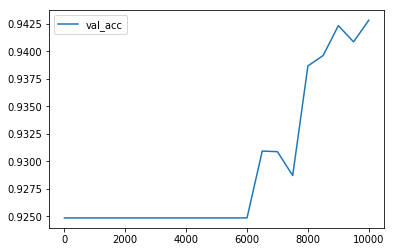

Ploting time: 0.175 s
New best saving time: 2.833 s
Epoch: 1/8 Iteration: 10010 Train loss: 0.039
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 10020 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 10030 Train loss: 0.038
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 10040 Train loss: 0.032
10 Epochs training time: 0.187 s
Epoch: 1/8 Iteration: 10050 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 10060 Train loss: 0.028
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 10070 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 10080 Train loss: 0.031
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 10090 Train loss: 0.038
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 10100 Train loss: 0.023
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 10110 Train loss: 0.042
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 10120 Train loss: 0.044
10 Epochs training time: 0.184 s


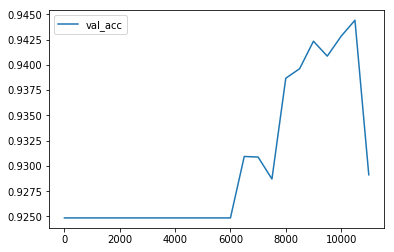

Ploting time: 0.169 s
Epoch: 1/8 Iteration: 11010 Train loss: 0.024
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 11020 Train loss: 0.013
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 11030 Train loss: 0.023
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 11040 Train loss: 0.074
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 11050 Train loss: 0.062
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 11060 Train loss: 0.069
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 11070 Train loss: 0.064
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 11080 Train loss: 0.068
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 11090 Train loss: 0.052
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 11100 Train loss: 0.055
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 11110 Train loss: 0.067
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 11120 Train loss: 0.050
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 11130 Tr

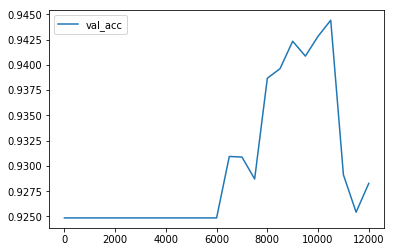

Ploting time: 0.17 s
Epoch: 1/8 Iteration: 12010 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 12020 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 12030 Train loss: 0.047
10 Epochs training time: 0.183 s
Epoch: 1/8 Iteration: 12040 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 12050 Train loss: 0.038
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 12060 Train loss: 0.054
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 12070 Train loss: 0.046
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 12080 Train loss: 0.031
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 12090 Train loss: 0.045
10 Epochs training time: 0.183 s
Epoch: 1/8 Iteration: 12100 Train loss: 0.034
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 12110 Train loss: 0.046
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 12120 Train loss: 0.038
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 12130 Tra

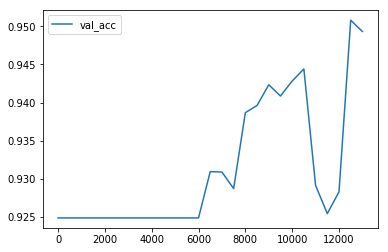

Ploting time: 0.198 s
Epoch: 1/8 Iteration: 13010 Train loss: 0.023
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 13020 Train loss: 0.024
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 13030 Train loss: 0.035
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 13040 Train loss: 0.045
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 13050 Train loss: 0.025
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 13060 Train loss: 0.072
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 13070 Train loss: 0.029
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 13080 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 13090 Train loss: 0.045
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 13100 Train loss: 0.070
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 13110 Train loss: 0.052
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 13120 Train loss: 0.041
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 13130 Tr

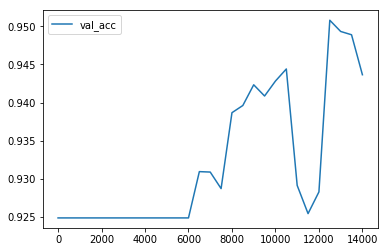

Ploting time: 1.487 s
Epoch: 1/8 Iteration: 14010 Train loss: 0.071
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 14020 Train loss: 0.044
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 14030 Train loss: 0.064
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 14040 Train loss: 0.085
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 14050 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 14060 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 14070 Train loss: 0.037
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 14080 Train loss: 0.091
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 14090 Train loss: 0.067
10 Epochs training time: 0.187 s
Epoch: 1/8 Iteration: 14100 Train loss: 0.054
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 14110 Train loss: 0.085
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 14120 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 14130 Tr

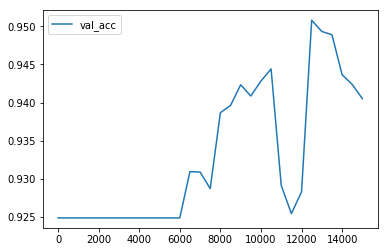

Ploting time: 0.195 s
Epoch: 1/8 Iteration: 15010 Train loss: 0.028
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 15020 Train loss: 0.057
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 15030 Train loss: 0.060
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 15040 Train loss: 0.063
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 15050 Train loss: 0.051
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 15060 Train loss: 0.082
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 15070 Train loss: 0.046
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 15080 Train loss: 0.067
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 15090 Train loss: 0.054
10 Epochs training time: 0.186 s
Epoch: 1/8 Iteration: 15100 Train loss: 0.059
10 Epochs training time: 0.187 s
Epoch: 1/8 Iteration: 15110 Train loss: 0.054
10 Epochs training time: 0.185 s
Epoch: 1/8 Iteration: 15120 Train loss: 0.041
10 Epochs training time: 0.184 s
Epoch: 1/8 Iteration: 15130 Tr

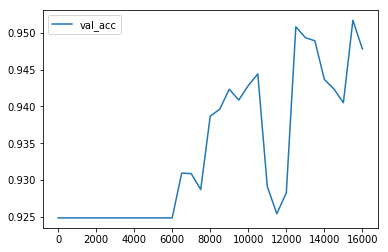

Ploting time: 0.236 s
Epoch: 2/8 Iteration: 16010 Train loss: 0.027
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 16020 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 16030 Train loss: 0.046
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 16040 Train loss: 0.023
10 Epochs training time: 0.187 s
Epoch: 2/8 Iteration: 16050 Train loss: 0.033
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 16060 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 16070 Train loss: 0.050
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 16080 Train loss: 0.029
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 16090 Train loss: 0.024
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 16100 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 16110 Train loss: 0.026
10 Epochs training time: 0.184 s
Epoch: 2/8 Iteration: 16120 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 16130 Tr

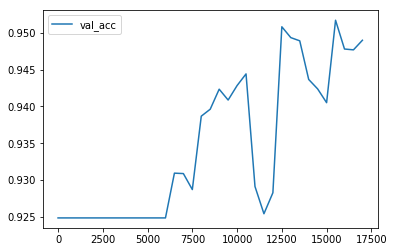

Ploting time: 0.195 s
Epoch: 2/8 Iteration: 17010 Train loss: 0.026
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 17020 Train loss: 0.026
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 17030 Train loss: 0.027
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 17040 Train loss: 0.014
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 17050 Train loss: 0.033
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 17060 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 17070 Train loss: 0.034
10 Epochs training time: 0.187 s
Epoch: 2/8 Iteration: 17080 Train loss: 0.023
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 17090 Train loss: 0.031
10 Epochs training time: 0.184 s
Epoch: 2/8 Iteration: 17100 Train loss: 0.029
10 Epochs training time: 0.184 s
Epoch: 2/8 Iteration: 17110 Train loss: 0.031
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 17120 Train loss: 0.031
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 17130 Tr

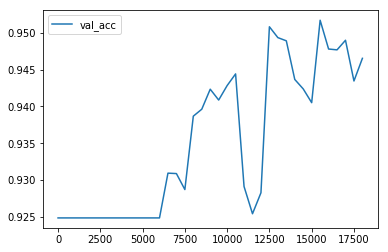

Ploting time: 0.199 s
Epoch: 2/8 Iteration: 18010 Train loss: 0.042
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 18020 Train loss: 0.038
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 18030 Train loss: 0.028
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 18040 Train loss: 0.038
10 Epochs training time: 0.187 s
Epoch: 2/8 Iteration: 18050 Train loss: 0.025
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 18060 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 18070 Train loss: 0.058
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 18080 Train loss: 0.038
10 Epochs training time: 0.187 s
Epoch: 2/8 Iteration: 18090 Train loss: 0.025
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 18100 Train loss: 0.039
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 18110 Train loss: 0.021
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 18120 Train loss: 0.033
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 18130 Tr

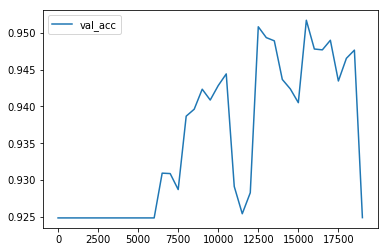

Ploting time: 0.206 s
Epoch: 2/8 Iteration: 19010 Train loss: 0.045
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 19020 Train loss: 0.046
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 19030 Train loss: 0.031
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 19040 Train loss: 0.022
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 19050 Train loss: 0.035
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 19060 Train loss: 0.069
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 19070 Train loss: 0.049
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 19080 Train loss: 0.050
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 19090 Train loss: 0.052
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 19100 Train loss: 0.040
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 19110 Train loss: 0.048
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 19120 Train loss: 0.057
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 19130 Tr

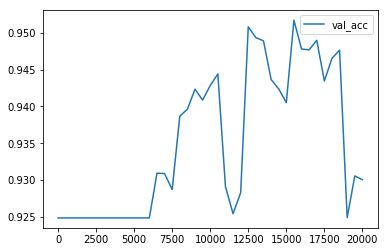

Ploting time: 0.168 s
Epoch: 2/8 Iteration: 20010 Train loss: 0.031
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 20020 Train loss: 0.042
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 20030 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 20040 Train loss: 0.031
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 20050 Train loss: 0.058
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 20060 Train loss: 0.020
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 20070 Train loss: 0.058
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 20080 Train loss: 0.034
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 20090 Train loss: 0.051
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 20100 Train loss: 0.042
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 20110 Train loss: 0.027
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 20120 Train loss: 0.040
10 Epochs training time: 0.187 s
Epoch: 2/8 Iteration: 20130 Tr

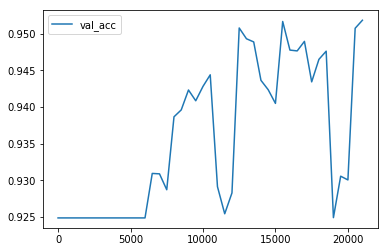

Ploting time: 0.191 s
New best saving time: 2.86 s
Epoch: 2/8 Iteration: 21010 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 21020 Train loss: 0.022
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 21030 Train loss: 0.046
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 21040 Train loss: 0.033
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 21050 Train loss: 0.041
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 21060 Train loss: 0.049
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 21070 Train loss: 0.076
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 21080 Train loss: 0.032
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 21090 Train loss: 0.054
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 21100 Train loss: 0.079
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 21110 Train loss: 0.049
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 21120 Train loss: 0.039
10 Epochs training time: 0.185 s
E

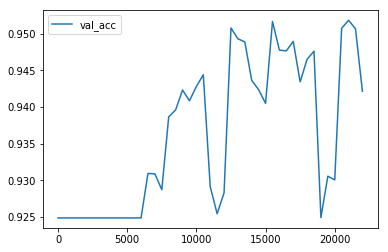

Ploting time: 0.187 s
Epoch: 2/8 Iteration: 22010 Train loss: 0.048
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 22020 Train loss: 0.056
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 22030 Train loss: 0.074
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 22040 Train loss: 0.040
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 22050 Train loss: 0.032
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 22060 Train loss: 0.065
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 22070 Train loss: 0.065
10 Epochs training time: 0.187 s
Epoch: 2/8 Iteration: 22080 Train loss: 0.048
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 22090 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 22100 Train loss: 0.044
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 22110 Train loss: 0.041
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 22120 Train loss: 0.029
10 Epochs training time: 0.187 s
Epoch: 2/8 Iteration: 22130 Tr

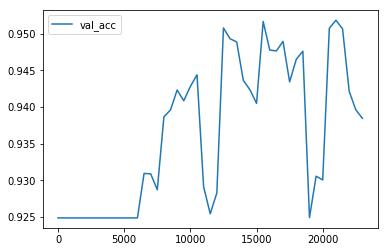

Ploting time: 0.155 s
Epoch: 2/8 Iteration: 23010 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 23020 Train loss: 0.060
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 23030 Train loss: 0.067
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 23040 Train loss: 0.070
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 23050 Train loss: 0.038
10 Epochs training time: 0.187 s
Epoch: 2/8 Iteration: 23060 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 23070 Train loss: 0.043
10 Epochs training time: 0.187 s
Epoch: 2/8 Iteration: 23080 Train loss: 0.056
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 23090 Train loss: 0.062
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 23100 Train loss: 0.051
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 23110 Train loss: 0.063
10 Epochs training time: 0.186 s
Epoch: 2/8 Iteration: 23120 Train loss: 0.048
10 Epochs training time: 0.185 s
Epoch: 2/8 Iteration: 23130 Tr

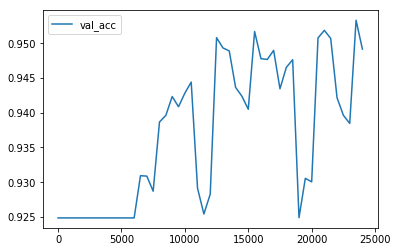

Ploting time: 0.215 s
Epoch: 3/8 Iteration: 24010 Train loss: 0.028
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 24020 Train loss: 0.016
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 24030 Train loss: 0.039
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 24040 Train loss: 0.030
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 24050 Train loss: 0.019
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 24060 Train loss: 0.020
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 24070 Train loss: 0.012
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 24080 Train loss: 0.025
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 24090 Train loss: 0.022
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 24100 Train loss: 0.021
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 24110 Train loss: 0.021
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 24120 Train loss: 0.024
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 24130 Tr

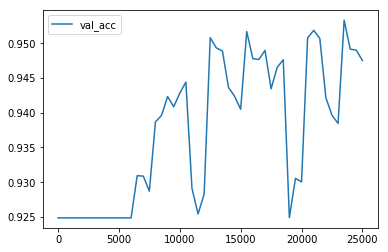

Ploting time: 0.193 s
Epoch: 3/8 Iteration: 25010 Train loss: 0.019
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 25020 Train loss: 0.011
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 25030 Train loss: 0.026
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 25040 Train loss: 0.008
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 25050 Train loss: 0.034
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 25060 Train loss: 0.031
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 25070 Train loss: 0.039
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 25080 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 25090 Train loss: 0.020
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 25100 Train loss: 0.028
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 25110 Train loss: 0.016
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 25120 Train loss: 0.026
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 25130 Tr

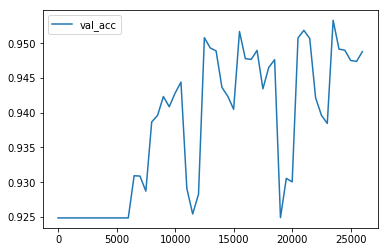

Ploting time: 0.158 s
Epoch: 3/8 Iteration: 26010 Train loss: 0.049
10 Epochs training time: 0.187 s
Epoch: 3/8 Iteration: 26020 Train loss: 0.023
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 26030 Train loss: 0.038
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 26040 Train loss: 0.025
10 Epochs training time: 0.187 s
Epoch: 3/8 Iteration: 26050 Train loss: 0.021
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 26060 Train loss: 0.042
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 26070 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 26080 Train loss: 0.064
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 26090 Train loss: 0.028
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 26100 Train loss: 0.023
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 26110 Train loss: 0.029
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 26120 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 26130 Tr

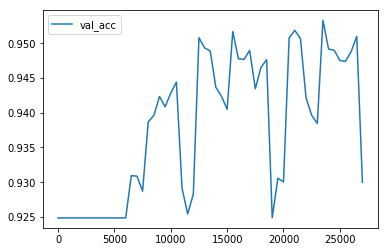

Ploting time: 0.193 s
Epoch: 3/8 Iteration: 27010 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 27020 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 27030 Train loss: 0.052
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 27040 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 27050 Train loss: 0.044
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 27060 Train loss: 0.027
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 27070 Train loss: 0.024
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 27080 Train loss: 0.025
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 27090 Train loss: 0.048
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 27100 Train loss: 0.019
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 27110 Train loss: 0.023
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 27120 Train loss: 0.049
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 27130 Tr

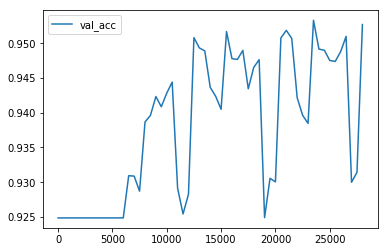

Ploting time: 0.18 s
Epoch: 3/8 Iteration: 28010 Train loss: 0.037
10 Epochs training time: 0.187 s
Epoch: 3/8 Iteration: 28020 Train loss: 0.039
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 28030 Train loss: 0.036
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 28040 Train loss: 0.045
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 28050 Train loss: 0.028
10 Epochs training time: 0.187 s
Epoch: 3/8 Iteration: 28060 Train loss: 0.010
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 28070 Train loss: 0.046
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 28080 Train loss: 0.029
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 28090 Train loss: 0.032
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 28100 Train loss: 0.023
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 28110 Train loss: 0.022
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 28120 Train loss: 0.020
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 28130 Tra

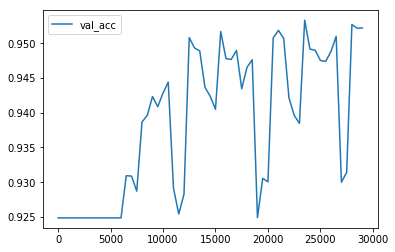

Ploting time: 0.199 s
Epoch: 3/8 Iteration: 29010 Train loss: 0.027
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 29020 Train loss: 0.033
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 29030 Train loss: 0.048
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 29040 Train loss: 0.048
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 29050 Train loss: 0.048
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 29060 Train loss: 0.044
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 29070 Train loss: 0.063
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 29080 Train loss: 0.054
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 29090 Train loss: 0.044
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 29100 Train loss: 0.049
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 29110 Train loss: 0.050
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 29120 Train loss: 0.050
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 29130 Tr

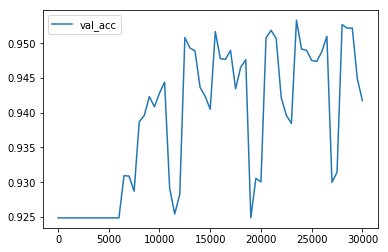

Ploting time: 0.163 s
Epoch: 3/8 Iteration: 30010 Train loss: 0.041
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 30020 Train loss: 0.058
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 30030 Train loss: 0.045
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 30040 Train loss: 0.040
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 30050 Train loss: 0.055
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 30060 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 30070 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 30080 Train loss: 0.062
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 30090 Train loss: 0.033
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 30100 Train loss: 0.027
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 30110 Train loss: 0.048
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 30120 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 30130 Tr

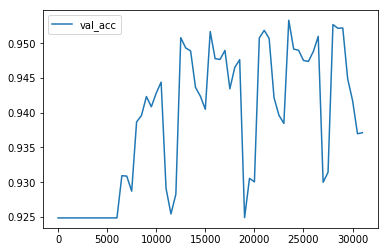

Ploting time: 0.158 s
Epoch: 3/8 Iteration: 31010 Train loss: 0.041
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 31020 Train loss: 0.066
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 31030 Train loss: 0.061
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 31040 Train loss: 0.078
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 31050 Train loss: 0.053
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 31060 Train loss: 0.033
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 31070 Train loss: 0.048
10 Epochs training time: 0.184 s
Epoch: 3/8 Iteration: 31080 Train loss: 0.057
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 31090 Train loss: 0.042
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 31100 Train loss: 0.069
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 31110 Train loss: 0.063
10 Epochs training time: 0.186 s
Epoch: 3/8 Iteration: 31120 Train loss: 0.050
10 Epochs training time: 0.185 s
Epoch: 3/8 Iteration: 31130 Tr

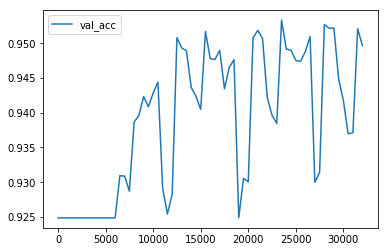

Ploting time: 0.231 s
Epoch: 4/8 Iteration: 32010 Train loss: 0.027
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 32020 Train loss: 0.046
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 32030 Train loss: 0.024
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 32040 Train loss: 0.041
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 32050 Train loss: 0.065
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 32060 Train loss: 0.038
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 32070 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 32080 Train loss: 0.024
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 32090 Train loss: 0.022
10 Epochs training time: 0.184 s
Epoch: 4/8 Iteration: 32100 Train loss: 0.044
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 32110 Train loss: 0.012
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 32120 Train loss: 0.030
10 Epochs training time: 0.184 s
Epoch: 4/8 Iteration: 32130 Tr

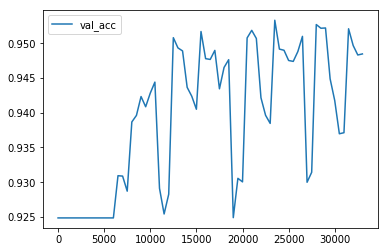

Ploting time: 0.2 s
Epoch: 4/8 Iteration: 33010 Train loss: 0.016
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 33020 Train loss: 0.021
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 33030 Train loss: 0.018
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 33040 Train loss: 0.025
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 33050 Train loss: 0.023
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 33060 Train loss: 0.045
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 33070 Train loss: 0.017
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 33080 Train loss: 0.038
10 Epochs training time: 0.187 s
Epoch: 4/8 Iteration: 33090 Train loss: 0.019
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 33100 Train loss: 0.016
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 33110 Train loss: 0.020
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 33120 Train loss: 0.026
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 33130 Trai

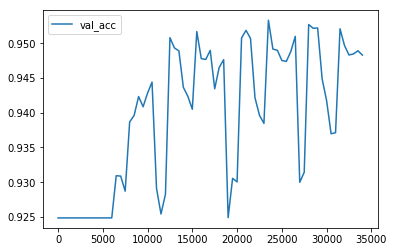

Ploting time: 0.2 s
Epoch: 4/8 Iteration: 34010 Train loss: 0.029
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 34020 Train loss: 0.015
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 34030 Train loss: 0.035
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 34040 Train loss: 0.033
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 34050 Train loss: 0.025
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 34060 Train loss: 0.018
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 34070 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 34080 Train loss: 0.034
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 34090 Train loss: 0.028
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 34100 Train loss: 0.021
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 34110 Train loss: 0.024
10 Epochs training time: 0.188 s
Epoch: 4/8 Iteration: 34120 Train loss: 0.029
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 34130 Trai

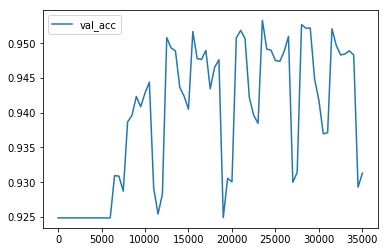

Ploting time: 0.206 s
Epoch: 4/8 Iteration: 35010 Train loss: 0.031
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 35020 Train loss: 0.042
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 35030 Train loss: 0.057
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 35040 Train loss: 0.033
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 35050 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 35060 Train loss: 0.045
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 35070 Train loss: 0.041
10 Epochs training time: 0.188 s
Epoch: 4/8 Iteration: 35080 Train loss: 0.053
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 35090 Train loss: 0.045
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 35100 Train loss: 0.046
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 35110 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 35120 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 35130 Tr

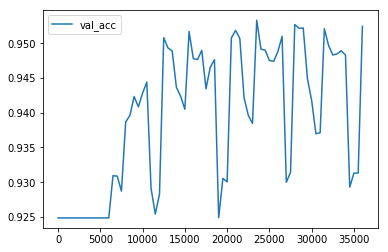

Ploting time: 0.207 s
Epoch: 4/8 Iteration: 36010 Train loss: 0.022
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 36020 Train loss: 0.024
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 36030 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 36040 Train loss: 0.013
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 36050 Train loss: 0.035
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 36060 Train loss: 0.017
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 36070 Train loss: 0.017
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 36080 Train loss: 0.026
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 36090 Train loss: 0.028
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 36100 Train loss: 0.023
10 Epochs training time: 0.187 s
Epoch: 4/8 Iteration: 36110 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 36120 Train loss: 0.047
10 Epochs training time: 0.187 s
Epoch: 4/8 Iteration: 36130 Tr

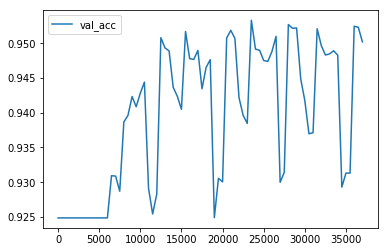

Ploting time: 0.198 s
Epoch: 4/8 Iteration: 37010 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 37020 Train loss: 0.055
10 Epochs training time: 0.184 s
Epoch: 4/8 Iteration: 37030 Train loss: 0.047
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 37040 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 37050 Train loss: 0.056
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 37060 Train loss: 0.028
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 37070 Train loss: 0.058
10 Epochs training time: 0.184 s
Epoch: 4/8 Iteration: 37080 Train loss: 0.047
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 37090 Train loss: 0.061
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 37100 Train loss: 0.055
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 37110 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 37120 Train loss: 0.023
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 37130 Tr

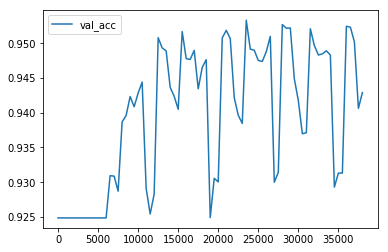

Ploting time: 0.206 s
Epoch: 4/8 Iteration: 38010 Train loss: 0.025
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 38020 Train loss: 0.032
10 Epochs training time: 0.187 s
Epoch: 4/8 Iteration: 38030 Train loss: 0.051
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 38040 Train loss: 0.059
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 38050 Train loss: 0.042
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 38060 Train loss: 0.069
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 38070 Train loss: 0.056
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 38080 Train loss: 0.042
10 Epochs training time: 0.187 s
Epoch: 4/8 Iteration: 38090 Train loss: 0.043
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 38100 Train loss: 0.033
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 38110 Train loss: 0.051
10 Epochs training time: 0.184 s
Epoch: 4/8 Iteration: 38120 Train loss: 0.027
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 38130 Tr

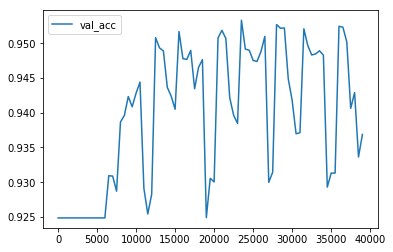

Ploting time: 0.213 s
Epoch: 4/8 Iteration: 39010 Train loss: 0.044
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 39020 Train loss: 0.034
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 39030 Train loss: 0.045
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 39040 Train loss: 0.059
10 Epochs training time: 0.188 s
Epoch: 4/8 Iteration: 39050 Train loss: 0.033
10 Epochs training time: 0.184 s
Epoch: 4/8 Iteration: 39060 Train loss: 0.046
10 Epochs training time: 0.184 s
Epoch: 4/8 Iteration: 39070 Train loss: 0.069
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 39080 Train loss: 0.067
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 39090 Train loss: 0.045
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 39100 Train loss: 0.048
10 Epochs training time: 0.185 s
Epoch: 4/8 Iteration: 39110 Train loss: 0.035
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 39120 Train loss: 0.050
10 Epochs training time: 0.186 s
Epoch: 4/8 Iteration: 39130 Tr

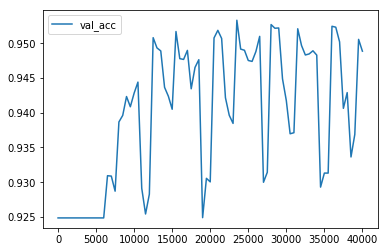

Ploting time: 0.193 s
Epoch: 5/8 Iteration: 40010 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 40020 Train loss: 0.018
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 40030 Train loss: 0.020
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 40040 Train loss: 0.018
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 40050 Train loss: 0.011
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 40060 Train loss: 0.030
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 40070 Train loss: 0.011
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 40080 Train loss: 0.026
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 40090 Train loss: 0.018
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 40100 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 40110 Train loss: 0.015
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 40120 Train loss: 0.020
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 40130 Tr

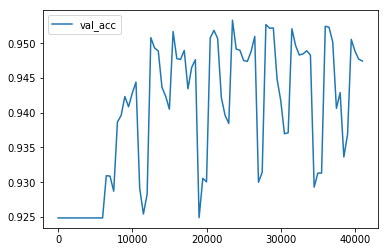

Ploting time: 0.187 s
Epoch: 5/8 Iteration: 41010 Train loss: 0.018
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 41020 Train loss: 0.026
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 41030 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 41040 Train loss: 0.027
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 41050 Train loss: 0.022
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 41060 Train loss: 0.009
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 41070 Train loss: 0.023
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 41080 Train loss: 0.019
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 41090 Train loss: 0.010
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 41100 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 41110 Train loss: 0.018
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 41120 Train loss: 0.013
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 41130 Tr

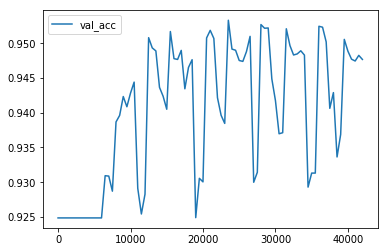

Ploting time: 0.185 s
Epoch: 5/8 Iteration: 42010 Train loss: 0.022
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 42020 Train loss: 0.041
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 42030 Train loss: 0.031
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 42040 Train loss: 0.032
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 42050 Train loss: 0.045
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 42060 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 42070 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 42080 Train loss: 0.025
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 42090 Train loss: 0.023
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 42100 Train loss: 0.024
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 42110 Train loss: 0.036
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 42120 Train loss: 0.028
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 42130 Tr

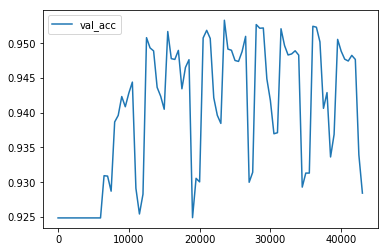

Ploting time: 0.167 s
Epoch: 5/8 Iteration: 43010 Train loss: 0.028
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 43020 Train loss: 0.027
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 43030 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 43040 Train loss: 0.052
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 43050 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 43060 Train loss: 0.034
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 43070 Train loss: 0.051
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 43080 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 43090 Train loss: 0.057
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 43100 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 43110 Train loss: 0.051
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 43120 Train loss: 0.032
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 43130 Tr

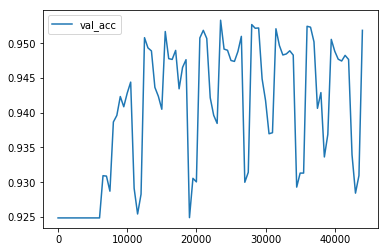

Ploting time: 0.198 s
Epoch: 5/8 Iteration: 44010 Train loss: 0.018
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 44020 Train loss: 0.017
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 44030 Train loss: 0.059
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 44040 Train loss: 0.037
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 44050 Train loss: 0.040
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 44060 Train loss: 0.025
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 44070 Train loss: 0.026
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 44080 Train loss: 0.014
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 44090 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 44100 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 44110 Train loss: 0.031
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 44120 Train loss: 0.018
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 44130 Tr

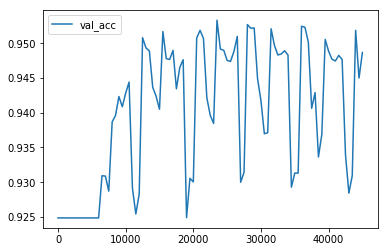

Ploting time: 0.191 s
Epoch: 5/8 Iteration: 45010 Train loss: 0.035
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 45020 Train loss: 0.051
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 45030 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 45040 Train loss: 0.044
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 45050 Train loss: 0.017
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 45060 Train loss: 0.021
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 45070 Train loss: 0.045
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 45080 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 45090 Train loss: 0.023
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 45100 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 45110 Train loss: 0.041
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 45120 Train loss: 0.022
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 45130 Tr

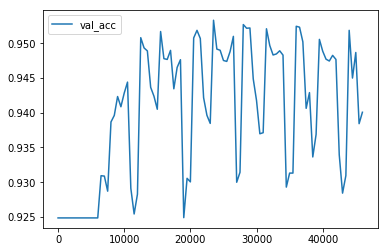

Ploting time: 0.192 s
Epoch: 5/8 Iteration: 46010 Train loss: 0.058
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 46020 Train loss: 0.052
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 46030 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 46040 Train loss: 0.041
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 46050 Train loss: 0.051
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 46060 Train loss: 0.066
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 46070 Train loss: 0.056
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 46080 Train loss: 0.033
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 46090 Train loss: 0.044
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 46100 Train loss: 0.026
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 46110 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 46120 Train loss: 0.025
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 46130 Tr

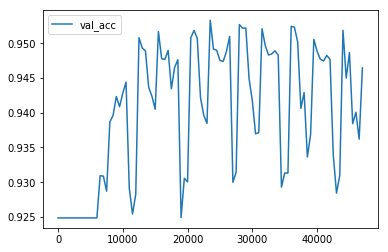

Ploting time: 0.171 s
Epoch: 5/8 Iteration: 47010 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 47020 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 47030 Train loss: 0.019
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 47040 Train loss: 0.029
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 47050 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 47060 Train loss: 0.026
10 Epochs training time: 0.187 s
Epoch: 5/8 Iteration: 47070 Train loss: 0.027
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 47080 Train loss: 0.022
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 47090 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 47100 Train loss: 0.002
10 Epochs training time: 0.186 s
Epoch: 5/8 Iteration: 47110 Train loss: 0.025
10 Epochs training time: 0.185 s
Epoch: 5/8 Iteration: 47120 Train loss: 0.016
10 Epochs training time: 0.184 s
Epoch: 5/8 Iteration: 47130 Tr

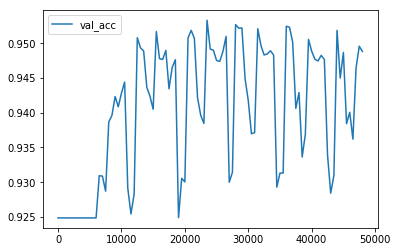

Ploting time: 0.195 s
Epoch: 6/8 Iteration: 48010 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 48020 Train loss: 0.025
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 48030 Train loss: 0.020
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 48040 Train loss: 0.028
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 48050 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 48060 Train loss: 0.024
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 48070 Train loss: 0.038
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 48080 Train loss: 0.033
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 48090 Train loss: 0.021
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 48100 Train loss: 0.023
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 48110 Train loss: 0.036
10 Epochs training time: 0.187 s
Epoch: 6/8 Iteration: 48120 Train loss: 0.021
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 48130 Tr

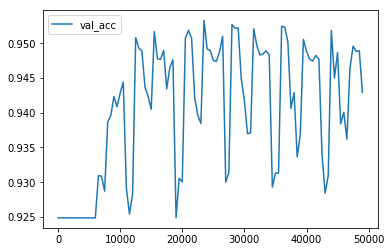

Ploting time: 0.192 s
Epoch: 6/8 Iteration: 49010 Train loss: 0.028
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 49020 Train loss: 0.033
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 49030 Train loss: 0.011
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 49040 Train loss: 0.017
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 49050 Train loss: 0.019
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 49060 Train loss: 0.034
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 49070 Train loss: 0.021
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 49080 Train loss: 0.016
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 49090 Train loss: 0.015
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 49100 Train loss: 0.017
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 49110 Train loss: 0.014
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 49120 Train loss: 0.017
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 49130 Tr

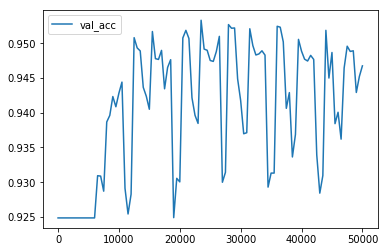

Ploting time: 0.195 s
Epoch: 6/8 Iteration: 50010 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 50020 Train loss: 0.024
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 50030 Train loss: 0.028
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 50040 Train loss: 0.026
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 50050 Train loss: 0.022
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 50060 Train loss: 0.026
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 50070 Train loss: 0.020
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 50080 Train loss: 0.049
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 50090 Train loss: 0.023
10 Epochs training time: 0.187 s
Epoch: 6/8 Iteration: 50100 Train loss: 0.037
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 50110 Train loss: 0.022
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 50120 Train loss: 0.033
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 50130 Tr

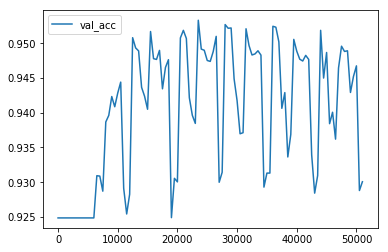

Ploting time: 0.211 s
Epoch: 6/8 Iteration: 51010 Train loss: 0.044
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 51020 Train loss: 0.019
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 51030 Train loss: 0.036
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 51040 Train loss: 0.035
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 51050 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 51060 Train loss: 0.065
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 51070 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 51080 Train loss: 0.033
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 51090 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 51100 Train loss: 0.034
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 51110 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 51120 Train loss: 0.042
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 51130 Tr

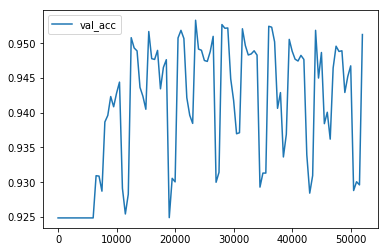

Ploting time: 0.155 s
Epoch: 6/8 Iteration: 52010 Train loss: 0.031
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 52020 Train loss: 0.029
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 52030 Train loss: 0.029
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 52040 Train loss: 0.020
10 Epochs training time: 0.187 s
Epoch: 6/8 Iteration: 52050 Train loss: 0.015
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 52060 Train loss: 0.027
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 52070 Train loss: 0.020
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 52080 Train loss: 0.027
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 52090 Train loss: 0.024
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 52100 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 52110 Train loss: 0.022
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 52120 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 52130 Tr

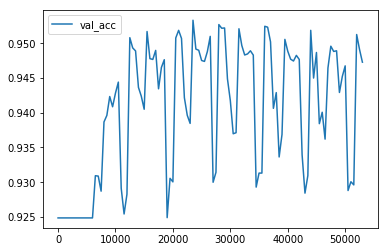

Ploting time: 0.156 s
Epoch: 6/8 Iteration: 53010 Train loss: 0.038
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 53020 Train loss: 0.030
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 53030 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 53040 Train loss: 0.060
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 53050 Train loss: 0.053
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 53060 Train loss: 0.038
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 53070 Train loss: 0.024
10 Epochs training time: 0.187 s
Epoch: 6/8 Iteration: 53080 Train loss: 0.049
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 53090 Train loss: 0.042
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 53100 Train loss: 0.046
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 53110 Train loss: 0.035
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 53120 Train loss: 0.046
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 53130 Tr

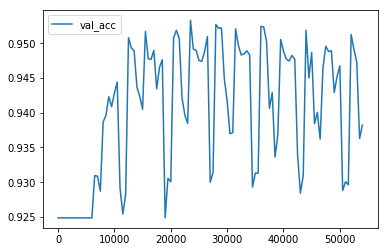

Ploting time: 0.196 s
Epoch: 6/8 Iteration: 54010 Train loss: 0.036
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 54020 Train loss: 0.042
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 54030 Train loss: 0.047
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 54040 Train loss: 0.037
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 54050 Train loss: 0.019
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 54060 Train loss: 0.042
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 54070 Train loss: 0.044
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 54080 Train loss: 0.036
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 54090 Train loss: 0.028
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 54100 Train loss: 0.050
10 Epochs training time: 0.183 s
Epoch: 6/8 Iteration: 54110 Train loss: 0.028
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 54120 Train loss: 0.032
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 54130 Tr

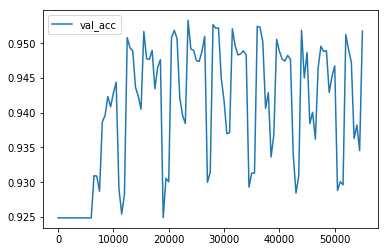

Ploting time: 0.197 s
Epoch: 6/8 Iteration: 55010 Train loss: 0.030
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 55020 Train loss: 0.016
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 55030 Train loss: 0.012
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 55040 Train loss: 0.009
10 Epochs training time: 0.184 s
Epoch: 6/8 Iteration: 55050 Train loss: 0.018
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 55060 Train loss: 0.011
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 55070 Train loss: 0.017
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 55080 Train loss: 0.016
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 55090 Train loss: 0.030
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 55100 Train loss: 0.011
10 Epochs training time: 0.186 s
Epoch: 6/8 Iteration: 55110 Train loss: 0.025
10 Epochs training time: 0.185 s
Epoch: 6/8 Iteration: 55120 Train loss: 0.015
10 Epochs training time: 0.187 s
Epoch: 6/8 Iteration: 55130 Tr

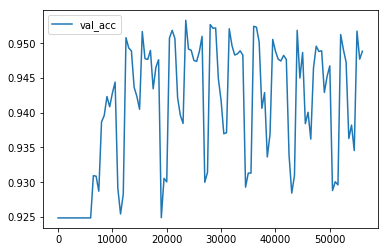

Ploting time: 0.23 s
Epoch: 7/8 Iteration: 56010 Train loss: 0.031
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 56020 Train loss: 0.010
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 56030 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 56040 Train loss: 0.025
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 56050 Train loss: 0.017
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 56060 Train loss: 0.015
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 56070 Train loss: 0.043
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 56080 Train loss: 0.033
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 56090 Train loss: 0.026
10 Epochs training time: 0.186 s
Epoch: 7/8 Iteration: 56100 Train loss: 0.015
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 56110 Train loss: 0.029
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 56120 Train loss: 0.022
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 56130 Tra

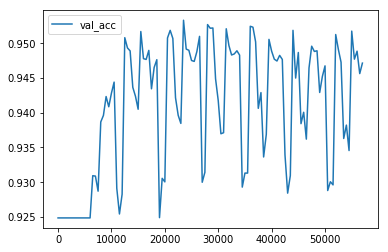

Ploting time: 0.199 s
Epoch: 7/8 Iteration: 57010 Train loss: 0.018
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 57020 Train loss: 0.018
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 57030 Train loss: 0.011
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 57040 Train loss: 0.019
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 57050 Train loss: 0.021
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 57060 Train loss: 0.016
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 57070 Train loss: 0.018
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 57080 Train loss: 0.012
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 57090 Train loss: 0.019
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 57100 Train loss: 0.040
10 Epochs training time: 0.186 s
Epoch: 7/8 Iteration: 57110 Train loss: 0.021
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 57120 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 57130 Tr

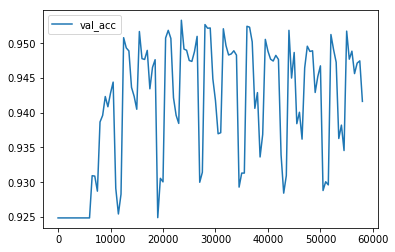

Ploting time: 0.18 s
Epoch: 7/8 Iteration: 58010 Train loss: 0.020
10 Epochs training time: 0.189 s
Epoch: 7/8 Iteration: 58020 Train loss: 0.014
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 58030 Train loss: 0.023
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 58040 Train loss: 0.033
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 58050 Train loss: 0.034
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 58060 Train loss: 0.015
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 58070 Train loss: 0.018
10 Epochs training time: 0.186 s
Epoch: 7/8 Iteration: 58080 Train loss: 0.021
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 58090 Train loss: 0.012
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 58100 Train loss: 0.015
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 58110 Train loss: 0.009
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 58120 Train loss: 0.028
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 58130 Tra

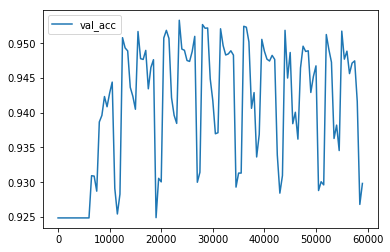

Ploting time: 0.165 s
Epoch: 7/8 Iteration: 59010 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 59020 Train loss: 0.019
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 59030 Train loss: 0.021
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 59040 Train loss: 0.023
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 59050 Train loss: 0.044
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 59060 Train loss: 0.024
10 Epochs training time: 0.187 s
Epoch: 7/8 Iteration: 59070 Train loss: 0.022
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 59080 Train loss: 0.033
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 59090 Train loss: 0.039
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 59100 Train loss: 0.032
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 59110 Train loss: 0.016
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 59120 Train loss: 0.031
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 59130 Tr

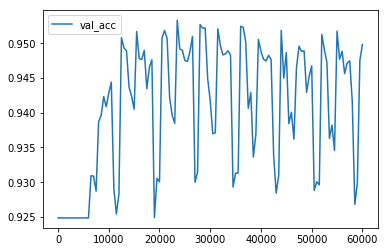

Ploting time: 0.189 s
Epoch: 7/8 Iteration: 60010 Train loss: 0.017
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 60020 Train loss: 0.031
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 60030 Train loss: 0.013
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 60040 Train loss: 0.025
10 Epochs training time: 0.183 s
Epoch: 7/8 Iteration: 60050 Train loss: 0.012
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 60060 Train loss: 0.018
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 60070 Train loss: 0.023
10 Epochs training time: 0.186 s
Epoch: 7/8 Iteration: 60080 Train loss: 0.035
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 60090 Train loss: 0.034
10 Epochs training time: 0.186 s
Epoch: 7/8 Iteration: 60100 Train loss: 0.028
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 60110 Train loss: 0.035
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 60120 Train loss: 0.024
10 Epochs training time: 0.186 s
Epoch: 7/8 Iteration: 60130 Tr

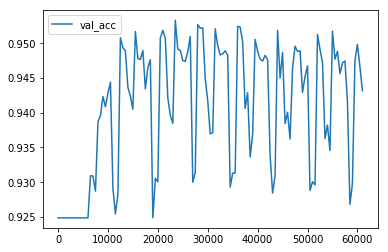

Ploting time: 0.185 s
Epoch: 7/8 Iteration: 61010 Train loss: 0.049
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 61020 Train loss: 0.046
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 61030 Train loss: 0.055
10 Epochs training time: 0.187 s
Epoch: 7/8 Iteration: 61040 Train loss: 0.029
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 61050 Train loss: 0.024
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 61060 Train loss: 0.030
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 61070 Train loss: 0.041
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 61080 Train loss: 0.025
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 61090 Train loss: 0.034
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 61100 Train loss: 0.042
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 61110 Train loss: 0.032
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 61120 Train loss: 0.042
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 61130 Tr

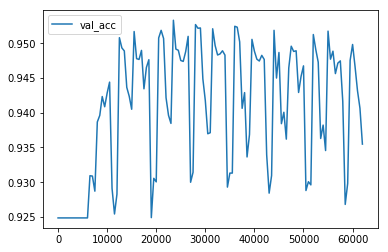

Ploting time: 0.196 s
Epoch: 7/8 Iteration: 62010 Train loss: 0.031
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 62020 Train loss: 0.039
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 62030 Train loss: 0.024
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 62040 Train loss: 0.030
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 62050 Train loss: 0.036
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 62060 Train loss: 0.050
10 Epochs training time: 0.186 s
Epoch: 7/8 Iteration: 62070 Train loss: 0.029
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 62080 Train loss: 0.042
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 62090 Train loss: 0.044
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 62100 Train loss: 0.033
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 62110 Train loss: 0.043
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 62120 Train loss: 0.037
10 Epochs training time: 0.185 s
Epoch: 7/8 Iteration: 62130 Tr

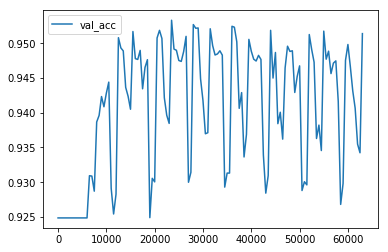

Ploting time: 0.203 s
Epoch: 7/8 Iteration: 63010 Train loss: 0.018
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 63020 Train loss: 0.031
10 Epochs training time: 0.184 s
Epoch: 7/8 Iteration: 63030 Train loss: 0.033
10 Epochs training time: 0.185 s
Total time: 13102.125 s
FINISH !!!!


In [ ]:
from time import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline


print("START")
t0 = time()



with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    iteration = 0
    
    with open(file_output, "r+") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(cathegory)
    
        epochs_stat = []
        iteration_stat = []
        val_accs_stat = []
        best_val_accs = 0
        
        
        for e in range(num_epochs):
            state = sess.run(initial_state)
            

            for ii, (x, y, wort) in enumerate(get_batches(train_x, train_y, train_woerter, batch_size), 1):
                
                #Training the network (after every batch the weights gets updated)
                t1 = time()
                
                feed = {inputs_: x,
                        labels_: y[:,None],
                        keep_prob: 0.6,
                        initial_state: state}  # normally 0.5 (0.6 - 0.7 for best results so far)
                loss, state, _ = sess.run([cost, final_state, optimizer], feed_dict=feed)

                #Print out status
                if iteration%10==0:
                    print("Epoch: {}/{}".format(e, num_epochs),
                          "Iteration: {}".format(iteration),
                          "Train loss: {:.3f}".format(loss))
                    print("10 Epochs training time:", round(time()-t1, 3), "s")
                

                if iteration%500==0:
                    
                    #Validation set accuracy
                    t2 = time()
                    
                    val_acc = []
                    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
                    for x, y, wort in get_batches(val_x, val_y, val_woerter, batch_size):
                        feed = {inputs_: x,
                                labels_: y[:,None],
                                keep_prob: 1,
                                initial_state: val_state}
                        batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                        val_acc.append(batch_acc)
                    print("Val acc: {:.3f}".format(np.mean(val_acc)))
                    
                    val_accs = np.mean(val_acc)
                    
                    to_write = [e] + [iteration] + [val_accs]
                    writer.writerow(to_write)
                    
                    epochs_stat.append(e)
                    iteration_stat.append(iteration)
                    val_accs_stat.append(val_accs)
                    
                    print("1 Validation time:", round(time()-t2, 3), "s")
                    
                    
                    #Safe checkpoint if it is better than prior results
                    t4 = time()
                    
                    if best_val_accs < val_accs:
                        best_val_accs = val_accs
                        saver.save(sess, "checkpoints/best.ckpt")
                        print("New best saving time:", round(time()-t4, 3), "s")
                        
                        
                if iteration%1000==0:
                    
                    #Plot a graph with the validation and training accuracies
                    t3 = time()
                    
                    plt.figure()
                    plt.plot(iteration_stat, val_accs_stat, label="val_acc")
                    plt.legend()
                    _ = plt.ylim()
                    plt.show()
                    plt.pause(0.0001) #Just to show the plot
                    
                    print("Ploting time:", round(time()-t3, 3), "s")
                       
                
                iteration +=1
                
                        
    #saver.save(sess, "checkpoints/last.ckpt")
    print("Total time:", round(time()-t0, 3), "s")
    
    print("FINISH !!!!")

In [111]:
print("Kernel still alive :)")

Kernel still alive :)


# Valididation accuracy graph

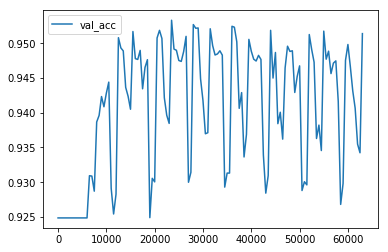

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(iteration_stat, val_accs_stat, label="val_acc")
plt.legend()
_ = plt.ylim()
plt.show()


# Testing


In [113]:
test_acc = []
with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y, wort) in enumerate(get_batches(test_x, test_y, test_woerter, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: test_state}
        batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
        test_acc.append(batch_acc)
    print("Test accuracy: {:.3f}".format(np.mean(test_acc)))

Test accuracy: 0.958


### Show samples of testing batch
Gives really good insights by showing:
prediction, label, text

In [114]:
predictions_list = []
batch_size = 256
counter_max = 3

with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
    
    counter = 0
    
    for ii, (x, y, wort) in enumerate(get_batches(test_x, test_y, test_woerter, batch_size), 1):
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: val_state}
        prediction = sess.run(predictions, feed_dict=feed)
    
        for i in range(0,len(prediction)):
            predictions_list.append([round(float(prediction[i]),4), y[i], wort[i]])
        
        ###    
        if counter == counter_max:
            break
        counter += 1
        ###
        
        
        
prediction_list = list(predictions_list)
for iii in range(0, len(predictions_list)):
    print(predictions_list[iii])
#print(predictions_list)   
    

[0.0098, 0, 'sie']
[0.0523, 0, 'die']
[0.0228, 0, 'karton']
[0.0096, 0, 'und']
[0.0164, 0, 'and']
[0.0102, 0, 'kleinteil']
[0.0671, 0, 'in']
[0.0062, 0, 'der']
[0.0044, 0, 'pension']
[0.0062, 0, 'abgelad']
[0.0076, 0, 'hatt']
[0.6258, 1, 'begann']
[0.015, 0, 'hild']
[0.9266, 0, 'damit']
[0.0058, 1, 'sich']
[0.1885, 0, 'in']
[0.0849, 0, 'ihr']
[0.0109, 0, 'zimm']
[0.0554, 0, 'einzuricht']
[0.1038, 1, 'philipps']
[0.0049, 0, 'mutt']
[0.3754, 0, 'half']
[0.0462, 0, 'ihr']
[0.1421, 1, 'das']
[0.0232, 0, 'notig']
[0.0871, 0, 'aus']
[0.0317, 0, 'den']
[0.005, 0, 'karton']
[0.0075, 0, 'zu']
[0.0044, 0, 'hol']
[0.0045, 0, '.']
[0.0093, 0, 'die']
[0.0093, 0, 'and']
[0.9487, 0, 'holt']
[0.0052, 0, 'die']
[0.0046, 0, 'mobel']
[0.0052, 0, '.']
[0.2563, 0, 'philipp']
[0.0052, 0, 'und']
[0.0081, 0, 'sein']
[0.0047, 0, 'freund']
[0.0332, 0, 'trug']
[0.1186, 0, 'das']
[0.9553, 1, 'was']
[0.0074, 0, 'sie']
[0.0061, 0, 'konnt']
[0.0059, 0, 'und']
[0.1071, 0, 'schafft']
[0.0048, 0, 'es']
[0.0144, 0, 'sog

# USE TRAINED NEURONAL NET ON NEW TEXT

### Preprocess the input text

In [123]:
import time
import numpy as np
import tensorflow as tf
import re
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def preprocess(text_name, vocabs_to_int=vocabs_to_int, int_to_vocabs=int_to_vocabs):
    
    ## Open text file
    with open(text_name, "r", encoding="utf-8") as text:
        text = text.read()
    
    ## Filtering out page numbers
    text = re.sub(r'\n[0-9]+ \n', '', text)
    text = re.sub(r'\n\n[a-zA-Z] \n\n', '', text)
    
    ## Tokenizing
    woerter = word_tokenize(text)
    
    ## Stemming
    sno = nltk.stem.SnowballStemmer('german')
    woerter_stem = [sno.stem(wort) for wort in woerter]
    
    ## Lemmatization
    root = '/output/'
    #root = '/Users/Till/Dropbox/Deep Learning Udacity/deep-learning/KommasetzungAusweichordner'
    fileid = 'tiger_release_aug07.corrected.16012013.conll09'
    columntypes = ['ignore', 'words', 'ignore', 'ignore', 'pos']
    
    corp = nltk.corpus.ConllCorpusReader(root, fileid, columntypes, encoding='utf8')
    tagged_sents = corp.tagged_sents()
    tagger = UnigramTagger(corp.tagged_sents())
    w_classes = tagger.tag(woerter)
    
    woerter_classes = []

    ## Mark punctuation with a "c"
    for word in w_classes:
        if "$" in str(word[1]):
            word_class = word[0] + "c"
        else:
            word_class = word[1]
        woerter_classes.append(word_class)
        
    ## Sample doesn't have any commas so they also don't have to be removed
    
    ## Generate features with the use of look up table (if not in lookup table -> None)    
    woerter_ints_s = [vocabs_to_int[wort] if wort in vocabs_to_int else vocabs_to_int[None] for wort in woerter_stem]
    woerter_classes_ints_s = [vocabs_to_int[wort] if wort in vocabs_to_int else vocabs_to_int[None] for wort in woerter_classes]
    
    features_s = []
    feature_woerter_s = [get_batch(woerter_ints_s, idx, window_size=10) for idx in range(0,len(woerter_ints_s))]
    feature_classes_s =  [get_batch(woerter_classes_ints_s, idx, window_size=10) for idx in range(0,len(woerter_ints_s))]
    features_s = list(zip(feature_woerter_s, feature_classes_s))
    features_s = np.asarray(features).reshape(len(woerter_ints_s), -1)
    
    
    return features_s, woerter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [128]:
import time
import numpy as np
import tensorflow as tf
import re
from collections import Counter

import nltk
from nltk.tag import UnigramTagger
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def preprocess(text_name, vocabs_to_int=vocabs_to_int, int_to_vocabs=int_to_vocabs):
    ##Text öffnen
    with open(text_name, "r", encoding="utf-8") as text:
        text = text.read()
    
    #Filtering out the page numbers
    text = re.sub(r'\n[0-9]+ \n', '', text)
    text = re.sub(r'\n\n[a-zA-Z] \n\n', '', text)
    
    ## Tokenizing
    woerter = word_tokenize(text)
    
    ## Stemming
    sno = nltk.stem.SnowballStemmer('german')
    woerter_stem = [sno.stem(wort) for wort in woerter]
    
    ## Lemmatization
    root = '/output/'
    #root = '/Users/Till/Dropbox/Deep Learning Udacity/deep-learning/KommasetzungAusweichordner'
    fileid = 'tiger_release_aug07.corrected.16012013.conll09'
    columntypes = ['ignore', 'words', 'ignore', 'ignore', 'pos']
    
    corp = nltk.corpus.ConllCorpusReader(root, fileid, columntypes, encoding='utf8')
    tagged_sents = corp.tagged_sents()
    tagger = UnigramTagger(corp.tagged_sents())
    w_classes = tagger.tag(woerter)
    
    woerter_classes = []

     ## Mark punctuation with a "c"
    for word in w_classes:
        if "$" in str(word[1]):
            word_class = word[0] + "c"
        else:
            word_class = word[1]
        woerter_classes.append(word_class)
    
    ## Sample doesn't have any commas so they also don't have to be removed
    
    ## Generate features with the use of look up table (if not in lookup table -> None)   
    woerter_ints = [vocabs_to_int[wort] if wort in vocabs_to_int else vocabs_to_int[None] for wort in woerter_stem]
    woerter_classes_ints = [vocabs_to_int[wort] if wort in vocabs_to_int else vocabs_to_int[None] for wort in woerter_classes]
    
    
    ## Generate features
    features = []
    feature_woerter = [get_batch(woerter_ints, idx, window_size=10) for idx in range(0,len(woerter_ints))]
    feature_classes =  [get_batch(woerter_classes_ints, idx, window_size=10) for idx in range(0,len(woerter_ints))]
    features = list(zip(feature_woerter, feature_classes))
    features = np.asarray(features).reshape(len(woerter_ints), -1)
    
    return features, woerter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Predicting location of commas

In [132]:
predictions_list = []
batch_size = 256

with tf.Session(graph=graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint("checkpoints"))
    val_state = sess.run(cell.zero_state(batch_size, tf.float32))
    x, woerter = preprocess("test.txt")
    
    for ii, (x, y, wort) in enumerate(get_batches(x, test_y, woerter, batch_size), 1):
        
        feed = {inputs_: x,
                labels_: y[:, None],
                keep_prob: 1,
                initial_state: val_state}
        prediction = sess.run(predictions, feed_dict=feed)
    
        for i in range(0,len(prediction)):
            predictions_list.append([round(float(prediction[i]),4), wort[i]])
        
        
predictions_list = list(predictions_list)


for iii in predictions_list:
    print(iii)

[0.0307, 'Haupt-']
[0.0745, 'und']
[0.0045, 'Nebensätze']
[0.0048, ':']
[0.5758, 'Weil']
[0.0046, 'mir']
[0.0093, 'langweilig']
[0.0211, 'war']
[0.9705, 'rief']
[0.0058, 'ich']
[0.0164, 'meinen']
[0.0044, 'Freund']
[0.0059, 'an']
[0.0064, '.']
[0.0095, 'Er']
[0.0355, 'schlug']
[0.0082, 'vor']
[0.9557, 'dass']
[0.0397, 'ich']
[0.005, 'zu']
[0.0048, 'ihm']
[0.0048, 'kommen']
[0.0046, 'solle']
[0.0046, '.']
[0.0066, 'Ich']
[0.9243, 'fragte']
[0.0618, 'meine']
[0.0057, 'Mutter']
[0.9051, 'ob']
[0.0051, 'ich']
[0.0049, 'gehen']
[0.0061, 'könne']
[0.0052, '.']
[0.0352, 'Sie']
[0.0147, 'war']
[0.0074, 'einverstanden']
[0.0052, 'und']
[0.0081, 'wollte']
[0.4381, 'nur']
[0.7514, 'dass']
[0.0052, 'ich']
[0.1733, 'um']
[0.0054, '6']
[0.0075, 'wieder']
[0.0071, 'nach']
[0.0043, 'Hause']
[0.0052, 'komme']
[0.005, '.']
[0.3215, 'Nachdem']
[0.0052, 'ich']
[0.0074, 'an']
[0.0053, 'Toms']
[0.0045, 'Wohnungstür']
[0.0046, 'geklingelt']
[0.008, 'hatte']
[0.1361, 'ging']
[0.0047, 'sie']
[0.0059, 'auf']
[0

[0.0042, 'versuchen']
[0.005, '.']
[0.0082, '(']
[0.0579, 'Jean']
[0.0227, 'Paul']
[0.0236, ')']
[0.1428, 'Wären']
[0.0572, 'Sie']
[0.0687, 'bereit']
[0.1895, 'behinderte']
[0.0692, 'Kinder']
[0.0827, 'auszubilden']
[0.0048, '?']
[0.071, 'Nächtelang']
[0.0081, 'zu']
[0.0046, 'lesen']
[0.0131, 'das']
[0.0078, 'war']
[0.0265, 'ihre']
[0.2119, 'grosse']
[0.0055, 'Leidenschaft']
[0.0102, '.']
[0.0346, 'Ich']
[0.0519, 'finde']
[0.0139, 'es']
[0.0057, 'stinklangweilig']
[0.0547, 'den']
[0.038, 'ganzen']
[0.0054, 'Abend']
[0.1544, 'vor']
[0.0599, 'der']
[0.0099, 'Glotze']
[0.0067, 'zu']
[0.0044, 'sitzen']
[0.0044, '.']
[0.0211, 'Du']
[0.0058, 'scheinst']
[0.0827, 'heute']
[0.1017, 'nicht']
[0.1418, 'gerade']
[0.1017, 'gut']
[0.0704, 'gelaunt']
[0.0245, 'zu']
[0.0055, 'sein']
[0.0045, '!']
[0.0065, 'Sie']
[0.1262, 'hinderten']
[0.0156, 'den']
[0.0046, 'Einbrecher']
[0.0986, 'daran']
[0.0795, 'aus']
[0.0707, 'dem']
[0.0667, 'Fenster']
[0.0367, 'zu']
[0.0088, 'steigen']
[0.023, '.']
[0.0262, 'Di

## Putting it back in a textual format
Commas with a prediction higher than the upper_gate will be added with ",". Predictions just higher that the lower_gate will be added with "(,)"

In [133]:
import string

def retext(upper_gate, lower_gate, pred = predictions_list):
    text = [t[1] for t in pred]
    
    for i in range(1, len(pred)):
        if pred[i][0] >= upper_gate:
            text[i-1] = str(text[i-1]) + ","
        elif  upper_gate > pred[i][0] >= lower_gate:
            text[i-1] = str(text[i-1]) + "(,)"
    
        if str(pred[i][1]) in str(string.punctuation):
            text[i-1] = text[i-1] + text[i]
            text[i] = "XXX"
            
    text = [te for te in text if "XXX" not in te]
    ready_text = " ".join(text)
    return ready_text

In [138]:
retext(0.9, 0.4)

'Haupt- und Nebensätze: Weil mir langweilig war, rief ich meinen Freund an. Er schlug vor, dass ich zu ihm kommen solle. Ich, fragte meine Mutter, ob ich gehen könne. Sie war einverstanden und wollte(,) nur(,) dass ich um 6 wieder nach Hause komme. Nachdem ich an Toms Wohnungstür geklingelt hatte ging sie auf und sein Hund sprang auf mich zu. Wenn er mich(,) so stürmisch begrüßt ist mir immer etwas mulmig zumute. Bevor er mich fressen konnte rief Tom ihn zurück. Nachdem Struppi sich beruhigt hatte ließ er sich von mir hinter den Schlappohren kraulen. Dann(,) fragte mich Tom ob ich das neueste Kunststück sehen wollte, das sie einstudiert hatten. Bevor ich etwas sagen konnte brachte Struppi in seinem Maul 3 kleine Bälle und legte sie vor Toms Füßen ab. Der, nahm sie und begann damit zu jonglieren. Als er zwischendurch immer einen Ball auf sein angezogenes Knie fallen ließ und ihn von dort wieder noch oben kicken wollte schnappte sich Struppi diesen Ball. Ich applaudierte. Nachdem er dies

### This is just a preversion version!!! The time wasn't sufficient to increase performance to a generell knowledge. There are still tones of possible improvments and ideas. To get the best possible performance it is still really important to train it on the right sort of text and tune the decision bounderies (from which prediction possiblity level on it will really set the comma) by hand . For more formal texts, later on a different data set was used. Because of time and money constraints the training resources were really limited. Also the excess to good and clean data sets, without having access to online language corpuses (often just accessibly if enrolled at a university), was harder than expected.